## 2024NewParams: Generator parameters and profiles

This notebook writes (9):

* gen_prop.csv
* genfuel_prop.csv
* gencost_prop.csv
* thermal_params.csv
* genmax_profile_{year}.csv
* genmin_profile_{year}.csv
* gencost0_profile_{year}.csv
* gencost1_profile_{year}.csv
* gencost_startup_profile_{year}.csv

The following files need to be created separately (7):

* bus_prop.csv
* branch_prop.csv
* dcline_prop.csv
* esr_prop.csv
* if_lims_prop.csv
* if_map_prop.csv
* load_profile_{year}.csv

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

import nygrid.gen_params as gp

In [2]:
# Set up directories
cwd = os.getcwd()
if 'examples' in cwd:
    parent_dir = os.path.dirname(cwd)
    data_dir = os.path.join(parent_dir, 'data')
else:
    data_dir = os.path.join(cwd, 'data')

grid_data_dir = os.path.join(data_dir, 'grid')
if not os.path.exists(grid_data_dir):
    raise FileNotFoundError('Grid data directory not found.')

thermal_data_dir = os.path.join(data_dir, 'thermal')
if not os.path.exists(thermal_data_dir):
    raise FileNotFoundError('Thermal data directory not found.')

print('Grid data directory: {}'.format(grid_data_dir))
print('Thermal data directory: {}'.format(thermal_data_dir))

solar_data_dir = os.path.join(data_dir, 'renewable', 'solar')
print('Solar data directory: {}'.format(solar_data_dir))

onshore_wind_data_dir = os.path.join(data_dir, 'renewable', 'onshore_wind')
print('Onshore wind data directory: {}'.format(onshore_wind_data_dir))

offshore_wind_data_dir = os.path.join(data_dir, 'renewable', 'offshore_wind')
print('Offshore wind data directory: {}'.format(offshore_wind_data_dir))

nyiso_data_dir = os.path.join(data_dir, 'from_nyiso')
print('NYISO data directory: {}'.format(nyiso_data_dir))

Grid data directory: /mnt/Bo_HDD/NYgrid-python/data/grid
Thermal data directory: /mnt/Bo_HDD/NYgrid-python/data/thermal
Solar data directory: /mnt/Bo_HDD/NYgrid-python/data/renewable/solar
Onshore wind data directory: /mnt/Bo_HDD/NYgrid-python/data/renewable/onshore_wind
Offshore wind data directory: /mnt/Bo_HDD/NYgrid-python/data/renewable/offshore_wind
NYISO data directory: /mnt/Bo_HDD/NYgrid-python/data/from_nyiso


# Read generator parameters

In [3]:
# Read processed generator parameters
thermal_params_df = pd.read_excel(os.path.join(
    thermal_data_dir, 'gen_params_2018.xlsx'), index_col=0)
thermal_params_df_2 = pd.read_excel(os.path.join(
    thermal_data_dir, 'gen_params_2024.xlsx'), index_col=0)
thermal_params_df = pd.concat([thermal_params_df, thermal_params_df_2], axis=0)

In [4]:
# 2024 NYCA: 218 thermal generators
gen_combiner_2024 = pd.read_excel(os.path.join(thermal_data_dir, '2024_nyca_thermal.xlsx'),
                                  sheet_name='matched_with_id_filtered')
gen_combiner_2024 = gen_combiner_2024.rename(columns={
    '   Station        Unit': 'NYISO_Name'})

# Map unit type GT, JE to CT
gen_combiner_2024['Unit Type'] = gen_combiner_2024['Unit Type'].replace(
    {'GT': 'CT', 'JE': 'CT'})
gen_combiner_2024['Fuel Type Secondary'] = gen_combiner_2024['Fuel Type Secondary'].astype(
    str).replace({'nan': ''})
gen_combiner_2024 = gen_combiner_2024.set_index('ID')
gen_combiner_2024 = gen_combiner_2024.sort_values(
    by=['CAMD_Plant_ID', 'CAMD_Unit_ID'])

thermal_params_2024 = thermal_params_df.loc[gen_combiner_2024.index]
thermal_params_2024 = thermal_params_2024.join(
    gen_combiner_2024[['Zone', 'gen_bus']])
thermal_params_2024 = thermal_params_2024[[
    'NYISO_Name', 'PTID', 'Unit_Type', 'Fuel_Type_Primary',
    'Fuel_Type_Secondary', 'CAMD_Plant_ID', 'CAMD_Unit_ID',
    'raise_rr_ratio', 'lower_rr_ratio',
    'max_gen', 'eco_min', 'eco_min_ratio',
    'heat_1', 'heat_0', 'gen_bus', 'Zone'
]]

# Calculate ramp rates
thermal_params_2024['max_ramp_ratio'] = thermal_params_2024[[
    'raise_rr_ratio', 'lower_rr_ratio']].max(axis=1)
thermal_params_2024['max_ramp_hourly'] = thermal_params_2024['max_ramp_ratio'] * \
    thermal_params_2024['max_gen']

# Sort by CAMD plant and unit ID
thermal_params_2024 = thermal_params_2024.sort_values(
    by=['CAMD_Plant_ID', 'CAMD_Unit_ID'])
thermal_params_2024 = thermal_params_2024.reset_index()

# Format generator properties

## 1. Thermal generators (CC, CT, ST)

In [5]:
# 2024 NYCA: 218 thermal generators
thermal_prop_2024 = gp.format_gen_prop_thermal(thermal_params_2024)

## 2. Nuclear

In [6]:
# Read nuclear generator parameters
nuclear_params_2024 = pd.read_excel(os.path.join(thermal_data_dir, '2024_nyca_nonthermal.xlsx'),
                                    sheet_name='Nuclear')
nuclear_params_2024['Unit Type'] = nuclear_params_2024['Unit Type'].replace(
    {'NP': 'NU', 'NB': 'NU'})
nuclear_params_2024['max_ramp_hourly'] = 0.2 * \
    nuclear_params_2024['Capacity (MW)']

# 2024 NYCA: 4 nuclear generators
nuclear_prop_2024 = gp.format_gen_prop_non_thermal(nuclear_params_2024)

## 3. Hydro

In [7]:
# Read hydro generator parameters
hydro_params_2024 = pd.read_excel(os.path.join(thermal_data_dir, '2024_nyca_nonthermal.xlsx'),
                                  sheet_name='Hydro')
hydro_params_2024['max_ramp_hourly'] = hydro_params_2024['Capacity (MW)']

# 2024 NYCA: 10 hydro generators
hydro_prop_2024 = gp.format_gen_prop_non_thermal(hydro_params_2024)

## 4. Import

In [8]:
# Read import generator parameters
import_params_2024 = pd.read_excel(os.path.join(thermal_data_dir, '2024_nyca_nonthermal.xlsx'),
                                   sheet_name='Import')
import_params_2024['max_ramp_hourly'] = import_params_2024['Capacity (MW)']

# 2024 NYCA: 15 import generators
import_prop_2024 = gp.format_gen_prop_non_thermal(import_params_2024)

## 5. Wind

In [9]:
# Read wind generator parameters
wind_params_2024 = pd.read_excel(os.path.join(thermal_data_dir, '2024_nyca_nonthermal.xlsx'),
                                 sheet_name='Wind')
wind_params_2024['max_ramp_hourly'] = wind_params_2024['Capacity (MW)']

# 2024 NYCA: 31 wind generators
wind_prop_2024 = gp.format_gen_prop_non_thermal(wind_params_2024)

## 6. Utility PV

In [10]:
# Read utility-scale PV generator parameters
upv_params_2024 = pd.read_excel(os.path.join(thermal_data_dir, '2024_nyca_nonthermal.xlsx'),
                                sheet_name='UPV')
upv_params_2024['max_ramp_hourly'] = upv_params_2024['Capacity (MW)']

# 2024 NYCA: 12 UPV generators
upv_prop_2024 = gp.format_gen_prop_non_thermal(upv_params_2024)

## 7. Other renewables

In [11]:
# Read other renewable generator parameters
others_params_2024 = pd.read_excel(os.path.join(thermal_data_dir, '2024_nyca_nonthermal.xlsx'),
                                   sheet_name='Others')
others_params_2024['max_ramp_hourly'] = others_params_2024['Capacity (MW)']

# 2024 NYCA: 18 other renewable generators
others_prop_2024 = gp.format_gen_prop_non_thermal(others_params_2024)

## 8. Combine generator properties

In [12]:
# 2024 NYCA: 321 generators
gen_prop_2024 = pd.concat([thermal_prop_2024,
                           nuclear_prop_2024,
                           hydro_prop_2024,
                           import_prop_2024,
                           wind_prop_2024,
                           upv_prop_2024,
                           others_prop_2024], axis=0)

# Format generator profiles

## 1. genmax profile

### A. Land-based wind

In [13]:
# Land-based wind generation profile at turbine level
onshore_wind_gen = pd.read_csv(os.path.join(onshore_wind_data_dir, f'current_wind_gen_1hr.csv'),
                               parse_dates=['Time'], index_col='Time').asfreq('H')
onshore_wind_gen.columns = onshore_wind_gen.columns.astype(int)

In [14]:
# Read wind turbine information
uswtdb_ny_2024 = pd.read_excel(os.path.join(
    onshore_wind_data_dir, 'uswtdb_2024_ny.xlsx'))

# Create a dict of NYISO name and USWTDB name
wind_names_2024 = dict(zip(wind_params_2024['Notes'],
                           wind_params_2024['Name']))

In [15]:
# 2024 NYCA: 31 wind generators
wind_farm_ts_dict = dict()
for name in wind_names_2024:
    wind_farm_df = uswtdb_ny_2024[uswtdb_ny_2024['p_name'] == name]
    wind_farm_idx = list(wind_farm_df.index)
    wind_farm_ts = onshore_wind_gen.loc[:, wind_farm_idx].sum(axis=1)
    wind_farm_ts_dict[name] = wind_farm_ts
wind_genmax_profile_2024 = pd.DataFrame(wind_farm_ts_dict)

# Remove timezone info
wind_genmax_profile_2024.index = wind_genmax_profile_2024.index.tz_localize(
    None)

# Convert kW to MW
wind_genmax_profile_2024 = wind_genmax_profile_2024 / 1000

# Rename wind farms
wind_genmax_profile_2024 = wind_genmax_profile_2024.rename(
    columns=wind_names_2024)

### B. Utility PV

In [16]:
# Utility PV generation profile
# Fixed tilt: 4 sites
upv_gen_ft = pd.read_csv(os.path.join(solar_data_dir, 'upv_params_2024_ft_solar_gen_1hr_MW.csv'),
                         parse_dates=['Time'], index_col='Time').asfreq('H')
# Single-axis tracking: 8 sites
upv_gen_sat = pd.read_csv(os.path.join(solar_data_dir, 'upv_params_2024_sat_solar_gen_1hr_MW.csv'),
                          parse_dates=['Time'], index_col='Time').asfreq('H')


In [17]:
# 2024 NYCA: 12 UPV generators
upv_genmax_profile_2024 = pd.concat([upv_gen_ft, upv_gen_sat], axis=1)

# Reorder columns
upv_genmax_profile_2024 = upv_genmax_profile_2024[upv_params_2024['Name']]

# Remove timezone info
upv_genmax_profile_2024.index = upv_genmax_profile_2024.index.tz_localize(None)

### C. Import

In [18]:
# Read NYISO historical interface flow data
interflow_2018 = pd.read_csv(os.path.join(nyiso_data_dir, 'interflowHourly_2018.csv'),
                             parse_dates=['TimeStamp'])
interflow_2018 = interflow_2018.pivot(
    index='TimeStamp', columns='InterfaceName', values='FlowMWH')

# Internal interface flow
if_internal_2018 = interflow_2018[['CENTRAL EAST - VC', 'DYSINGER EAST', 'MOSES SOUTH',
                                  'SPR/DUN-SOUTH', 'TOTAL EAST', 'UPNY CONED', 'WEST CENTRAL']]

# External interface flow
if_external_2018 = interflow_2018[['SCH - HQ - NY', 'SCH - HQ_CEDARS', 'SCH - HQ_IMPORT_EXPORT',
                                  'SCH - NE - NY', 'SCH - NPX_1385', 'SCH - NPX_CSC',
                                   'SCH - OH - NY', 'SCH - PJ - NY', 'SCH - PJM_HTP',
                                   'SCH - PJM_NEPTUNE', 'SCH - PJM_VFT']]

In [19]:
# Assume that 2024 import generators have the same capacity as 2018
# 2018 NYCA: 15 import generators
import_genmax_profile_2024 = pd.DataFrame(index=if_external_2018.index)

# NE
import_genmax_profile_2024['Import_NE_CSC'] = if_external_2018['SCH - NPX_CSC']
import_genmax_profile_2024['Import_NE_NNC'] = if_external_2018['SCH - NPX_1385']
import_genmax_profile_2024['Import_NE_ZF'] = if_external_2018['SCH - NE - NY'] * 0.5
import_genmax_profile_2024['Import_NE_ZG'] = if_external_2018['SCH - NE - NY'] * 0.5

# IESO
import_genmax_profile_2024['Import_IESO_ZD'] = if_external_2018['SCH - OH - NY'] * 0.16
import_genmax_profile_2024['Import_IESO_ZA1'] = if_external_2018['SCH - OH - NY'] * 0.42
import_genmax_profile_2024['Import_IESO_ZA2'] = if_external_2018['SCH - OH - NY'] * 0.42

# PJM
import_genmax_profile_2024['Import_PJM_ZA'] = if_external_2018['SCH - PJ - NY'] * 0.175
import_genmax_profile_2024['Import_PJM_ZC'] = if_external_2018['SCH - PJ - NY'] * 0.285
import_genmax_profile_2024['Import_PJM_ZG'] = if_external_2018['SCH - PJ - NY'] * 0.54
import_genmax_profile_2024['Import_PJM_NEPTUNE'] = if_external_2018['SCH - PJM_NEPTUNE']
import_genmax_profile_2024['Import_PJM_HTP'] = if_external_2018['SCH - PJM_HTP']
import_genmax_profile_2024['Import_PJM_VFT'] = if_external_2018['SCH - PJM_VFT']

# HQ
import_genmax_profile_2024['Import_HQ_CEDARS'] = if_external_2018['SCH - HQ_CEDARS']
import_genmax_profile_2024['Import_HQ_NY'] = if_external_2018['SCH - HQ - NY']

In [20]:
for name in import_params_2024['Name']:
    p_max = import_params_2024.loc[import_params_2024['Name']
                                   == name, 'Capacity (MW)'].values[0]
    p_min = import_params_2024.loc[import_params_2024['Name']
                                   == name, 'min_gen'].values[0]
    import_genmax_profile_2024[name] = import_genmax_profile_2024[name].clip(
        p_min, p_max)

In [21]:
# 2024 NYCA: 16 import generators
import_genmax_profile_2024 = import_genmax_profile_2024.copy()

### D. Other renewables

In [22]:
# 2024 NYCA: 18 other renewable generators
# Assume that 2024 other renewable generators have the same capacity as 2018
others_genmax_profile_2024 = pd.read_excel(os.path.join(thermal_data_dir, '2018_profiles.xlsx'),
                                           sheet_name='Others_GenMax')
others_genmax_profile_2024 = others_genmax_profile_2024.set_index('TimeStamp')

### E. Combine genmax profiles

In [23]:
start_date = datetime(2018, 1, 1, 0, 0, 0)
end_date = datetime(2018, 12, 31, 23, 0, 0)
timestamp_list = pd.date_range(start_date, end_date, freq='1H')

In [24]:
thermal_genmax_profile_2024 = pd.DataFrame(
    np.tile(thermal_prop_2024['PMAX'].values, (8760, 1)),
    index=timestamp_list,
    columns=thermal_prop_2024['GEN_NAME'].values)

In [25]:
nuclear_genmax_profile_2024 = pd.DataFrame(
    np.tile(nuclear_prop_2024['PMAX'].values, (8760, 1)),
    index=timestamp_list,
    columns=nuclear_prop_2024['GEN_NAME'].values)

In [26]:
hydro_genmax_profile_2024 = pd.DataFrame(
    np.tile(hydro_prop_2024['PMAX'].values, (8760, 1)),
    index=timestamp_list,
    columns=hydro_prop_2024['GEN_NAME'].values)

In [27]:
genmax_profile_2024 = pd.concat([thermal_genmax_profile_2024,
                                 nuclear_genmax_profile_2024,
                                 hydro_genmax_profile_2024,
                                 import_genmax_profile_2024,
                                 wind_genmax_profile_2024,
                                 upv_genmax_profile_2024,
                                 others_genmax_profile_2024,
                                 ], axis=1)

## 2. gen min profile

In [28]:
thermal_genmin_profile_2024 = pd.DataFrame(
    np.tile(thermal_prop_2024['PMIN'].values, (8760, 1)),
    index=timestamp_list,
    columns=thermal_prop_2024['GEN_NAME'].values)

In [29]:
nuclear_genmin_profile_2024 = pd.DataFrame(
    np.tile(nuclear_prop_2024['PMIN'].values, (8760, 1)),
    index=timestamp_list,
    columns=nuclear_prop_2024['GEN_NAME'].values)

In [30]:
hydro_genmin_profile_2024 = pd.DataFrame(
    np.tile(hydro_prop_2024['PMIN'].values, (8760, 1)),
    index=timestamp_list,
    columns=hydro_prop_2024['GEN_NAME'].values)

In [31]:
import_genmin_profile_2024 = import_genmax_profile_2024.copy()

for name in import_params_2024['Name']:
    import_genmin_profile_2024[name] = np.where(import_genmin_profile_2024[name] < 0,
                                                import_genmin_profile_2024[name],
                                                0)

In [32]:
wind_genmin_profile_2024 = pd.DataFrame(
    np.tile(wind_prop_2024['PMIN'].values, (8760, 1)),
    index=timestamp_list,
    columns=wind_prop_2024['GEN_NAME'].values)

In [33]:
upv_genmin_profile_2024 = pd.DataFrame(
    np.tile(upv_prop_2024['PMIN'].values, (8760, 1)),
    index=timestamp_list,
    columns=upv_prop_2024['GEN_NAME'].values)

In [34]:
others_genmin_profile_2024 = pd.DataFrame(
    np.tile(others_prop_2024['PMIN'].values, (8760, 1)),
    index=timestamp_list,
    columns=others_prop_2024['GEN_NAME'].values)

In [35]:
genmin_profile_2024 = pd.concat([thermal_genmin_profile_2024,
                                 nuclear_genmin_profile_2024,
                                 hydro_genmin_profile_2024,
                                 import_genmin_profile_2024,
                                 wind_genmin_profile_2024,
                                 upv_genmin_profile_2024,
                                 others_genmin_profile_2024,
                                 ], axis=1)

## 3. gen cost profile

### A. Thermal

In [36]:
# Read weekly fuel price profiles in 2018
fuel_price_profile_2018 = pd.read_csv(os.path.join(nyiso_data_dir, 'fuelPriceWeekly_2018.csv'),
                                      parse_dates=['TimeStamp'])
fuel_price_profile_2018 = fuel_price_profile_2018.set_index('TimeStamp')

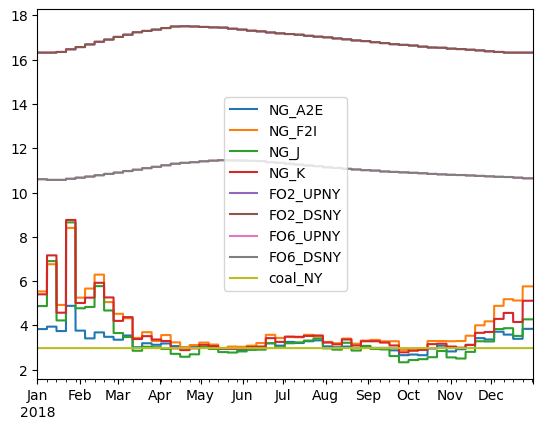

In [37]:
# Interpolate fuel price to hourly resolution
fuel_price_profile_2018 = fuel_price_profile_2018.reindex(
    timestamp_list, method='ffill')

fuel_price_profile_2018.plot()
plt.show()

In [38]:
# Assume that 2024 thermal generators have the same fuel price as 2018
fuel_price_profile_2024 = fuel_price_profile_2018.copy()

In [ ]:
# Calculate startup fuel requirements
thermal_params_2024['eco_min_heat_input'] = thermal_params_2024['heat_0'] + \
    thermal_params_2024['heat_1'] * thermal_params_2024['eco_min']
thermal_params_2024[['NYISO_Name', 'eco_min_heat_input']]

,NYISO_Name,eco_min_heat_input
0,Danskammer 1,383.569563
1,Danskammer 2,242.024971
2,Danskammer 3,855.688525
3,Danskammer 4,618.678968
4,Arthur Kill ST 2,1056.039364
...,...,...
213,Bayonne EC CTG8,283.527187
214,Bayonne EC CTG9,298.457123
215,Cricket Valley CC1,1351.883034
216,Cricket Valley CC2,1340.540167


In [40]:
# 2024
thermal_cost_0_2024 = np.zeros((len(timestamp_list), len(thermal_params_2024)))
thermal_cost_1_2024 = np.zeros((len(timestamp_list), len(thermal_params_2024)))
thermal_cost_startup_2024 = np.zeros(
    (len(timestamp_list), len(thermal_params_2024)))

for i, row in thermal_params_2024.iterrows():
    zone = row['Zone']
    heat_0 = row['heat_0']
    heat_1 = row['heat_1']

    if row['Zone'] in ['A', 'B', 'C', 'D', 'E']:
        if row['Fuel_Type_Primary'] == 'NG':
            fuel_price = fuel_price_profile_2024['NG_A2E']
        elif row['Fuel_Type_Primary'] in ['FO2', 'KER']:
            fuel_price = fuel_price_profile_2024['FO2_UPNY']
        elif row['Fuel_Type_Primary'] == 'FO6':
            fuel_price = fuel_price_profile_2024['FO6_UPNY']
        elif row['Fuel_Type_Primary'] == 'BIT':
            fuel_price = fuel_price_profile_2024['coal_NY']
        else:
            raise ValueError('Fuel type not found.')

    elif row['Zone'] in ['F', 'G', 'H', 'I', 'J', 'K']:
        if row['Fuel_Type_Primary'] == 'NG':
            if row['Zone'] == 'J':
                fuel_price = fuel_price_profile_2024['NG_J']
            elif row['Zone'] == 'K':
                fuel_price = fuel_price_profile_2024['NG_K']
            else:
                fuel_price = fuel_price_profile_2024['NG_F2I']
        elif row['Fuel_Type_Primary'] in ['FO2', 'KER']:
            fuel_price = fuel_price_profile_2024['FO2_DSNY']
        elif row['Fuel_Type_Primary'] == 'FO6':
            fuel_price = fuel_price_profile_2024['FO6_DSNY']
        elif row['Fuel_Type_Primary'] == 'BIT':
            fuel_price = fuel_price_profile_2024['coal_NY']
        else:
            raise ValueError('Fuel type not found.')
    else:
        raise ValueError('Zone not found.')

    thermal_cost_0_2024[:, i] = row['heat_0'] * fuel_price
    thermal_cost_1_2024[:, i] = row['heat_1'] * fuel_price
    thermal_cost_startup_2024[:, i] = row['eco_min_heat_input'] * fuel_price

thermal_cost_0_2024 = pd.DataFrame(thermal_cost_0_2024, index=timestamp_list,
                                   columns=thermal_prop_2024['GEN_NAME'])
thermal_cost_1_2024 = pd.DataFrame(thermal_cost_1_2024, index=timestamp_list,
                                   columns=thermal_prop_2024['GEN_NAME'])
thermal_cost_startup_2024 = pd.DataFrame(thermal_cost_startup_2024, index=timestamp_list,
                                         columns=thermal_prop_2024['GEN_NAME'])

### B. Nuclear

In [41]:
# 2024
nuclear_cost_0_2024 = pd.DataFrame(np.zeros((len(timestamp_list), len(nuclear_params_2024))),
                                   index=timestamp_list,
                                   columns=nuclear_params_2024['Name'])

nuclear_cost_1_2024 = pd.DataFrame(np.ones((len(timestamp_list), len(nuclear_params_2024)))*2,
                                   index=timestamp_list,
                                   columns=nuclear_params_2024['Name'])

nuclear_cost_startup_2024 = pd.DataFrame(np.tile(nuclear_params_2024['Capacity (MW)']*100, (8760, 1)),
                                         index=timestamp_list,
                                         columns=nuclear_params_2024['Name'])

### C. Hydro

In [42]:
# 2024
hydro_cost_0_2024 = pd.DataFrame(np.zeros((len(timestamp_list), len(hydro_params_2024))),
                                 index=timestamp_list,
                                 columns=hydro_params_2024['Name'])

hydro_cost_1_2024 = pd.DataFrame(np.ones((len(timestamp_list), len(hydro_params_2024)))*1,
                                 index=timestamp_list,
                                 columns=hydro_params_2024['Name'])

hydro_cost_startup_2024 = pd.DataFrame(np.zeros((len(timestamp_list), len(hydro_params_2024))),
                                       index=timestamp_list,
                                       columns=hydro_params_2024['Name'])

### D. Import

In [43]:
# Read NYISO historical interface flow data
zonal_price_2018 = pd.read_csv(os.path.join(nyiso_data_dir, 'priceHourly_2018.csv'),
                               parse_dates=['TimeStamp'])
zonal_price_2018 = zonal_price_2018.pivot(
    index='TimeStamp', columns='ZoneName', values='LBMP')
external_price_2018 = zonal_price_2018[['NPX', 'O H', 'PJM', 'H Q']]
external_price_2018 = external_price_2018[external_price_2018.index.year == 2018]

In [44]:
# 2018 NYCA: 15 import generators
# Assume that 2024 import generators have the same external price as 2018
import_cost_1_2024 = pd.DataFrame(index=external_price_2018.index)

# NE
import_cost_1_2024['Import_NE_CSC'] = external_price_2018['NPX']
import_cost_1_2024['Import_NE_NNC'] = external_price_2018['NPX']
import_cost_1_2024['Import_NE_ZF'] = external_price_2018['NPX']
import_cost_1_2024['Import_NE_ZG'] = external_price_2018['NPX']

# IESO
import_cost_1_2024['Import_IESO_ZD'] = external_price_2018['O H']
import_cost_1_2024['Import_IESO_ZA1'] = external_price_2018['O H']
import_cost_1_2024['Import_IESO_ZA2'] = external_price_2018['O H']

# PJM
import_cost_1_2024['Import_PJM_ZA'] = external_price_2018['PJM']
import_cost_1_2024['Import_PJM_ZC'] = external_price_2018['PJM']
import_cost_1_2024['Import_PJM_ZG'] = external_price_2018['PJM']
import_cost_1_2024['Import_PJM_NEPTUNE'] = external_price_2018['PJM']
import_cost_1_2024['Import_PJM_HTP'] = external_price_2018['PJM']
import_cost_1_2024['Import_PJM_VFT'] = external_price_2018['PJM']

# HQ
import_cost_1_2024['Import_HQ_CEDARS'] = external_price_2018['H Q']
import_cost_1_2024['Import_HQ_NY'] = external_price_2018['H Q']

In [45]:
# 2018
import_cost_0_2024 = pd.DataFrame(np.zeros((len(timestamp_list), len(import_params_2024))),
                                  index=timestamp_list,
                                  columns=import_params_2024['Name'])

import_cost_startup_2024 = pd.DataFrame(np.zeros((len(timestamp_list), len(import_params_2024))),
                                        index=timestamp_list,
                                        columns=import_params_2024['Name'])

### E. Others

In [46]:
# 2024
others_cost_0_2024 = pd.DataFrame(np.zeros((len(timestamp_list), len(others_params_2024))),
                                  index=timestamp_list,
                                  columns=others_params_2024['Name'])

others_cost_1_2024 = pd.DataFrame(np.zeros((len(timestamp_list), len(others_params_2024))),
                                  index=timestamp_list,
                                  columns=others_params_2024['Name'])

others_cost_startup_2024 = pd.DataFrame(np.zeros((len(timestamp_list), len(others_params_2024))),
                                        index=timestamp_list,
                                        columns=others_params_2024['Name'])

### F. Wind

In [47]:
# 2024
wind_cost_0_2024 = pd.DataFrame(np.zeros((len(timestamp_list), len(wind_params_2024))),
                                index=timestamp_list,
                                columns=wind_params_2024['Name'])

wind_cost_1_2024 = pd.DataFrame(np.zeros((len(timestamp_list), len(wind_params_2024))),
                                index=timestamp_list,
                                columns=wind_params_2024['Name'])

wind_cost_startup_2024 = pd.DataFrame(np.zeros((len(timestamp_list), len(wind_params_2024))),
                                      index=timestamp_list,
                                      columns=wind_params_2024['Name'])

### G. Utility PV

In [48]:
# 2024
upv_cost_0_2024 = pd.DataFrame(np.zeros((len(timestamp_list), len(upv_params_2024))),
                               index=timestamp_list,
                               columns=upv_params_2024['Name'])

upv_cost_1_2024 = pd.DataFrame(np.zeros((len(timestamp_list), len(upv_params_2024))),
                               index=timestamp_list,
                               columns=upv_params_2024['Name'])

upv_cost_startup_2024 = pd.DataFrame(np.zeros((len(timestamp_list), len(upv_params_2024))),
                                     index=timestamp_list,
                                     columns=upv_params_2024['Name'])

### H. Combine gencost profiles

In [49]:
# 2024
gen_cost_0_profile_2024 = pd.concat([thermal_cost_0_2024,
                                     nuclear_cost_0_2024,
                                     hydro_cost_0_2024,
                                     import_cost_0_2024,
                                     wind_cost_0_2024,
                                     upv_cost_0_2024,
                                     others_cost_0_2024,
                                     ], axis=1)

gen_cost_1_profile_2024 = pd.concat([thermal_cost_1_2024,
                                     nuclear_cost_1_2024,
                                     hydro_cost_1_2024,
                                     import_cost_1_2024,
                                     wind_cost_1_2024,
                                     upv_cost_1_2024,
                                     others_cost_1_2024,
                                     ], axis=1)

gen_cost_startup_profile_2024 = pd.concat([thermal_cost_startup_2024,
                                           nuclear_cost_startup_2024,
                                           hydro_cost_startup_2024,
                                           import_cost_startup_2024,
                                           wind_cost_startup_2024,
                                           upv_cost_startup_2024,
                                           others_cost_startup_2024,
                                           ], axis=1)

In [50]:
# Gen cost property table
gen_cost_prop_2024 = pd.DataFrame(columns=['GEN_NAME', 'MODEL', 'STARTUP',
                                           'SHUTDOWN', 'NCOST', 'COST_1', 'COST_0'])
gen_cost_prop_2024['GEN_NAME'] = gen_cost_0_profile_2024.columns
gen_cost_prop_2024['MODEL'] = 2  # Linear cost model
gen_cost_prop_2024['STARTUP'] = gen_cost_startup_profile_2024.mean(
    axis=0).values
gen_cost_prop_2024['SHUTDOWN'] = 0
gen_cost_prop_2024['NCOST'] = 2
gen_cost_prop_2024['COST_1'] = gen_cost_1_profile_2024.mean(axis=0).values
gen_cost_prop_2024['COST_0'] = gen_cost_0_profile_2024.mean(axis=0).values

In [51]:
# Gen fuel property table
genfuel_prop_2024 = gen_prop_2024[[
    'GEN_NAME', 'UNIT_TYPE', 'FUEL_TYPE']].copy()
genfuel_prop_2024['GEN_FUEL'] = genfuel_prop_2024.apply(
    lambda x: x['UNIT_TYPE'] + '_' + x['FUEL_TYPE'], axis=1)
genfuel_prop_2024 = genfuel_prop_2024.drop(columns=['UNIT_TYPE', 'FUEL_TYPE'])
genfuel_prop_2024

,GEN_NAME,GEN_FUEL
0,"Danskammer 1(2480,1)",ST_NG
1,"Danskammer 2(2480,2)",ST_NG
2,"Danskammer 3(2480,3)",ST_NG
3,"Danskammer 4(2480,4)",ST_NG
4,"Arthur Kill ST 2(2490,20)",ST_NG
...,...,...
13,Other_F_4,Other_Other
14,Other_G_1,Other_Other
15,Other_H_1,Other_Other
16,Other_K_1,Other_Other


# Outputs

In [52]:
# Make sure the columns are in the same order
gen_order_2024 = gen_prop_2024['GEN_NAME']
genmax_profile_2024 = genmax_profile_2024[gen_order_2024]
genmin_profile_2024 = genmin_profile_2024[gen_order_2024]
gen_cost_0_profile_2024 = gen_cost_0_profile_2024[gen_order_2024]
gen_cost_1_profile_2024 = gen_cost_1_profile_2024[gen_order_2024]
gen_cost_startup_profile_2024 = gen_cost_startup_profile_2024[gen_order_2024]

genmax_profile_2024.index.name = 'TimeStamp'
genmin_profile_2024.index.name = 'TimeStamp'
gen_cost_0_profile_2024.index.name = 'TimeStamp'
gen_cost_1_profile_2024.index.name = 'TimeStamp'
gen_cost_startup_profile_2024.index.name = 'TimeStamp'

In [53]:
# Write to CSV
output_dir_2024 = os.path.join(grid_data_dir, '2024NewParams')
os.makedirs(output_dir_2024, exist_ok=True)

# Properties
gen_prop_2024.to_csv(os.path.join(
    output_dir_2024, 'gen_prop.csv'), index=False)
genfuel_prop_2024.to_csv(os.path.join(
    output_dir_2024, 'genfuel_prop.csv'), index=False)
gen_cost_prop_2024.to_csv(os.path.join(
    output_dir_2024, 'gencost_prop.csv'), index=False)
thermal_params_2024.to_csv(os.path.join(
    output_dir_2024, 'thermal_params.csv'), index=False)

# Profiles
genmax_profile_2024.to_csv(os.path.join(
    output_dir_2024, 'genmax_profile_2024.csv'))
genmin_profile_2024.to_csv(os.path.join(
    output_dir_2024, 'genmin_profile_2024.csv'))
gen_cost_0_profile_2024.to_csv(os.path.join(
    output_dir_2024, 'gencost0_profile_2024.csv'))
gen_cost_1_profile_2024.to_csv(os.path.join(
    output_dir_2024, 'gencost1_profile_2024.csv'))
gen_cost_startup_profile_2024.to_csv(os.path.join(
    output_dir_2024, 'gencost_startup_profile_2024.csv'))